# 케글 산탄데르 고객만족(Santandel Customer Satisfaction) 데이터 세트

### 케글 산탄데르 고객 만족 예측 대회

* 대회 개요
https://www.kaggle.com/c/santander-customer-satisfaction

- 불만고객(1) 분류하기
성능평가: ROC-AUC ( 대부분이 만족이고 불만족인 데이터는 소수인 불균형 데이터세트)

- 데이터셋 다운로드: 
https://www.kaggle.com/c/santander-customer-satisfaction/data

- 다운로드 후 데이터셋 이름 변경
train.csv -> train_santander.csv
test.csv -> test_santander.csv 

- XGBoost, LightGBM으로 예측

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./data/data/train_santander.csv",encoding='latin-1')
cust_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [17]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [18]:
cust_df.isnull().sum().sum()

0

### 데이터 전처리

*  레이블 (Target) 의 분포 확인(불만족 고객 비율)

In [19]:
cust_df.TARGET.value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [20]:
# 기초통계량
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [21]:
# var3 피처 값 대체 및 ID 피처 드롭

# cust_df.var3.value_counts()
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트(특성 데이터)와 레이블(TARGET) 세트분리. 
X = cust_df.iloc[:,:-1]
y = cust_df.iloc[:,-1]

X.shape,y.shape

((76020, 369), (76020,))

In [23]:
# train, test set 분리: test_size=0.2, random_state=0
# 불균형 데이터이므로 학습세트와 테스트세트에 레이블 분포가 유사한지 확인
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2, random_state=0,
                                                 stratify=y)

In [25]:
y_train.value_counts(normalize=True)

0    0.960438
1    0.039562
Name: TARGET, dtype: float64

In [26]:
y_test.value_counts(normalize=True)

0    0.960405
1    0.039595
Name: TARGET, dtype: float64

## 1. XGBoost 모델 

### XGBoost 모델 학습

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
?XGBClassifier.fit

In [ ]:
# n_estimators=500, random state=156

In [29]:
xgb = XGBClassifier(n_estimators = 500 , random_state = 156)

In [30]:
# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 

xgb.fit(X_train,y_train, early_stopping_rounds=100,
        eval_metric='auc', eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=True)

[0]	validation_0-auc:0.82570	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88674	validation_1-auc:0.82453
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=156, ...)

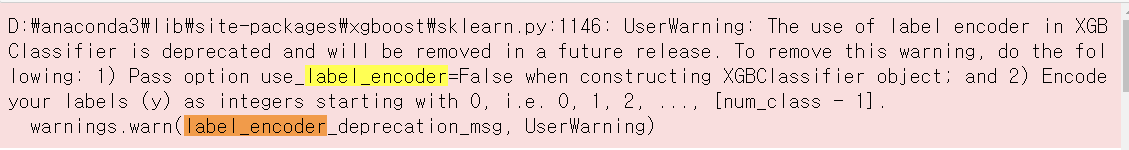

In [31]:
xgb.best_score

0.8250790293597428

In [ ]:
# warning 제거를 위해 y_train, y_test 자료구조를 numpy로 바꿔줌

#### 첫 번째 하이퍼파라미터 튜닝 (0.8404 -> ?? )

In [32]:
from sklearn.model_selection import GridSearchCV


# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)

params = {
    'max_depth' : [3, 5, 7],
    'min_child_weight' : [1,3],
    'colsample_bytree' : [0.5, 0.75]
}

# cv는 3으로 지정 
grid = GridSearchCV(xgb,param_grid=params, cv=3)
grid.fit(X_train,y_train,early_stopping_rounds=30, eval_metric='auc',
         eval_set = [(X_train,y_train),(X_test,y_test)])

[0]	validation_0-auc:0.78167	validation_1-auc:0.75531
[1]	validation_0-auc:0.80981	validation_1-auc:0.78496
[2]	validation_0-auc:0.81047	validation_1-auc:0.78302
[3]	validation_0-auc:0.81286	validation_1-auc:0.78341
[4]	validation_0-auc:0.81822	validation_1-auc:0.79186
[5]	validation_0-auc:0.82404	validation_1-auc:0.79802
[6]	validation_0-auc:0.81893	validation_1-auc:0.79352
[7]	validation_0-auc:0.83380	validation_1-auc:0.80727
[8]	validation_0-auc:0.83636	validation_1-auc:0.81062
[9]	validation_0-auc:0.83650	validation_1-auc:0.80634
[10]	validation_0-auc:0.83672	validation_1-auc:0.80491
[11]	validation_0-auc:0.83582	validation_1-auc:0.80253
[12]	validation_0-auc:0.84102	validation_1-auc:0.80882
[13]	validation_0-auc:0.84272	validation_1-auc:0.81227
[14]	validation_0-auc:0.84514	validation_1-auc:0.81422
[15]	validation_0-auc:0.84634	validation_1-auc:0.81429
[16]	validation_0-auc:0.84793	validation_1-auc:0.81640
[17]	validation_0-auc:0.84822	validation_1-auc:0.81762
[18]	validation_0-au

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3]})

In [33]:
grid.best_score_

0.9605202578268877

In [34]:
grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
grid.best_params_

{'colsample_bytree': 0.75, 'max_depth': 3, 'min_child_weight': 1}

In [37]:
roc_auc_score(y_test,grid.best_estimator_.predict_proba(X_test)[:,1])

0.8238791413909987

#### 두번째 하이퍼파라미터 튜닝.( 0. 8455 -> 0.8453)

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 


*  특성 중요도시각화

In [40]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

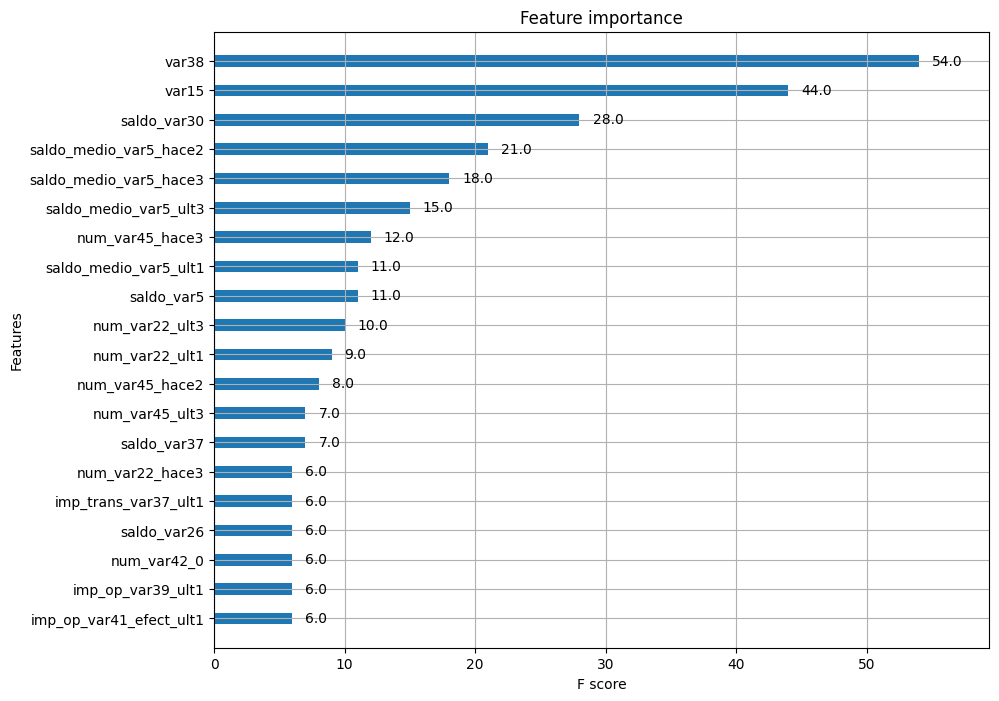

In [43]:
xgb = grid.best_estimator_
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb, ax=ax, max_num_features=20, height=0.4);

## 2.  LightGBM 모델 

In [ ]:
?LGBMClassifier.fit

####  첫번째 하이퍼 파라미터 튜닝(0.8409 -> ? 0.8417)

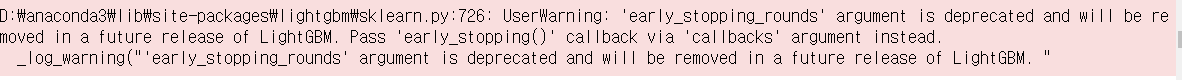

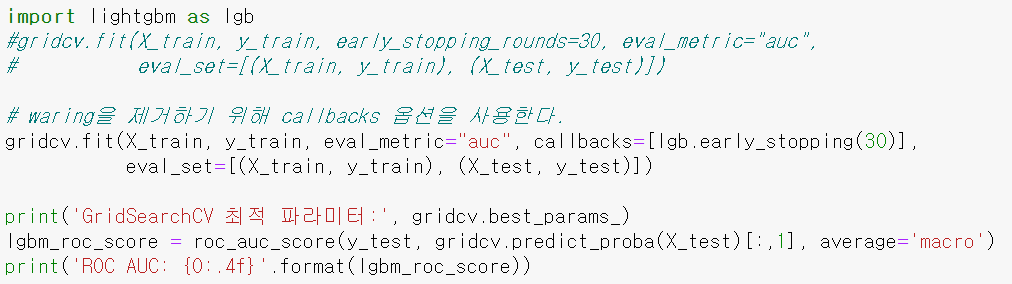

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64],
          'max_depth': [128, 160],
          'min_child_samples': [60, 100],
          'subsample': [0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
